In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

# 1 data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train_src,y_train_src),(x_test_src,y_test_src) = mnist.load_data('./mnist.npz')

In [3]:
print(x_train_src.shape,y_train_src.shape)
print(x_test_src.shape,y_test_src.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [4]:
_,m,n = x_train_src.shape

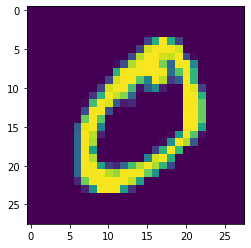

In [5]:
plt.imshow(x_train_src[1,:,:])
plt.show()

# 2 feature

In [6]:
x_train = x_train_src/255.
x_test = x_test_src/255.

In [7]:
y_train = y_train_src
y_test = y_test_src

# 3 model

In [8]:
x = tf.placeholder(shape=[None,m,n],dtype=tf.float32,name='x')
y = tf.placeholder(shape=[None],dtype=tf.int32,name='y')

In [9]:
seq_len = tf.placeholder(shape=[None],dtype=tf.int32,name='seq_len')

In [10]:
#rnncell = tf.contrib.rnn.BasicLSTMCell?

In [12]:
fw = tf.nn.rnn_cell.LSTMCell(100)
bw = tf.nn.rnn_cell.LSTMCell(100)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [13]:
_,((_,fw_last_state),(_,bw_last_state)) = tf.nn.bidirectional_dynamic_rnn(fw,bw,x,seq_len,dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
fw_last_state.shape

TensorShape([Dimension(None), Dimension(100)])

In [15]:
bw_last_state

<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_4:0' shape=(?, 100) dtype=float32>

In [16]:
output = tf.concat([fw_last_state,bw_last_state],axis = -1)

In [17]:
print(output.shape)

(?, 200)


In [18]:
w = tf.Variable(tf.truncated_normal(shape=[200,10],mean=0.,stddev=tf.sqrt(2.)*tf.sqrt(2./(10+100))),\
               dtype=tf.float32,name='w')

In [19]:
b = tf.Variable(tf.ones(shape=[10]),dtype=tf.float32,name='b')

In [20]:
logit = tf.nn.xw_plus_b(output,w, b,name='score')

In [21]:
print(logit.shape)

(?, 10)


In [22]:
#correct = tf.nn.in_top_k?

In [23]:
correct = tf.nn.in_top_k(logit,y,1,name ='correst')

In [24]:
acc = tf.reduce_mean(tf.cast(correct,tf.float32),name='acc')

# 4 loss

In [25]:
all_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit,labels=y,name='all_loss')

In [26]:
loss = tf.reduce_mean(all_loss)

# 5 optimize

In [27]:
optimize = tf.train.AdamOptimizer(learning_rate=3e-4,name='optimize')

In [28]:
train_op = optimize.minimize(loss)

# 6 init

In [29]:
init_op = tf.global_variables_initializer()

# 7 train

In [30]:
num_epochs = 100
batch_size = 128
num_batch = int(x_train.shape[0]/128) + 1

In [31]:
saver = tf.train.Saver()

In [33]:
def feed_batch(n_epochs,batch_index,batch_size,x_train,y_train):
    beg = (batch_index -1 )* batch_size
    end = batch_index * batch_size;
    
    return x_train[beg:end],y_train[beg:end],np.array([i.shape[0] for i in x_train[beg:end]])

In [34]:
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(num_epochs):
        for j in range(1,num_batch):
            sample_x,sample_y,sample_len = feed_batch(i,j,batch_size,x_train,y_train)
            #print(sample_x.shape,sample_y.shape,sample_len.shape)
            if j%100 == 0:
                acc_train,loss_train,_ = sess.run([acc,loss,train_op],\
                                                  feed_dict={x:sample_x,y:sample_y,seq_len:sample_len})
                acc_test = sess.run(acc,feed_dict={x:x_test,y:y_test,\
                                                   seq_len:np.array([i.shape[0] for i in x_test])})
                #print('%d\t%d\t%f\t%f\t%f'%(i,j,loss_train,acc_train,acc_test))
            else:
                _ = sess.run([train_op],feed_dict={x:sample_x,y:sample_y,seq_len:sample_len})
        acc_test,loss_test = sess.run([acc,loss],feed_dict={x:x_test,y:y_test,\
                                                        seq_len:np.array([i.shape[0] for i in x_test])})
        acc_train,loss_train = sess.run([acc,loss],feed_dict={x:x_train,y:y_train,\
                                                          seq_len:np.array([i.shape[0] for i in x_train])})
        print('%d\t%f\t%f\t%f\t%f'%(i,acc_train,loss_train,acc_test,loss_test))
        
    acc_test,loss_test = sess.run([acc,loss],feed_dict={x:x_test,y:y_test,\
                                                        seq_len:np.array([i.shape[0] for i in x_test])})
    acc_train,loss_train = sess.run([acc,loss],feed_dict={x:x_train,y:y_train,\
                                                          seq_len:np.array([i.shape[0] for i in x_train])})
    print('%f\t%f\t%f\t%f'%(acc_train,loss_train,acc_test,loss_test))
    saver.save(sess,'./model/bi-lstm')

0	0.899600	0.319163	0.900000	0.313290
1	0.945633	0.175427	0.946300	0.169624
2	0.957600	0.136469	0.959400	0.135623
3	0.966800	0.109309	0.965300	0.114169
4	0.972567	0.090116	0.971100	0.096820
5	0.974300	0.081203	0.972600	0.091707
6	0.977150	0.072377	0.974700	0.086327
7	0.979283	0.066138	0.974000	0.086376
8	0.979550	0.064979	0.974100	0.089528
9	0.982183	0.056671	0.975000	0.085227
10	0.982950	0.053818	0.975700	0.083277
11	0.984867	0.047686	0.975900	0.080601
12	0.986433	0.042782	0.976500	0.077604
13	0.987550	0.039045	0.976500	0.076853
14	0.989050	0.034468	0.977400	0.072674
15	0.988617	0.034539	0.977800	0.074597
16	0.988233	0.035883	0.976500	0.078061
17	0.987350	0.039498	0.978000	0.079656
18	0.991200	0.027087	0.980000	0.069018
19	0.988633	0.034654	0.977500	0.078417
20	0.991450	0.025834	0.979800	0.071113
21	0.989917	0.030940	0.979300	0.077648
22	0.992317	0.024637	0.980100	0.070330
23	0.991617	0.026210	0.979500	0.076695
24	0.991133	0.026505	0.978400	0.079720
25	0.991433	0.026116	0.979200	0.076

In [35]:
with tf.Session() as sess:
    saver.restore(sess,'./model/bi-lstm')
    acc_test,loss_test = sess.run([acc,loss],feed_dict={x:x_test,y:y_test,\
                                                        seq_len:np.array([i.shape[0] for i in x_test])})
    acc_train,loss_train = sess.run([acc,loss],feed_dict={x:x_train,y:y_train,\
                                                          seq_len:np.array([i.shape[0] for i in x_train])})
    print('%f\t%f\t%f\t%f'%(acc_train,loss_train,acc_test,loss_test))

INFO:tensorflow:Restoring parameters from ./model/bi-lstm
0.999983	0.000464	0.986600	0.083726


# 8 ckpt to pb for tf serving

In [36]:
tf.reset_default_graph()

In [37]:
tf.graph_util.convert_variables_to_constants?

In [38]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./model/rnn.meta')
    new_saver.restore(sess,'./model/rnn')
    
    ## conver variable to constant
    forzen_graph_def = tf.graph_util.\
    convert_variables_to_constants(\
                                   sess,sess.graph_def,output_node_names = ['score'])
    with open('rnn_graph.pb','wb') as f:
        f.write(forzen_graph_def.SerializePartialToString())
        pass

INFO:tensorflow:Restoring parameters from ./model/rnn
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.
